#### 타이타닉 생존자 예측 탐색적 데이터 분석 EDA (Exploratory Data Analysis)

In [2]:
# 사전 라이브러리 설치(XAI용, : 실현가능한 AI) : pip install sharp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # 성능이 안좋아지기 시작하면 멈추게 함
from sklearn.impute import SimpleImputer    # 결측치를 처리하는데 사용 / 트레인 데이터 평균값을 미리 계산하는 fillna와 비슷(mean해서 평균값을 집어넣던지 0을 집어넣는 것)
from sklearn.preprocessing import LabelEncoder    #범주형 데이터를 숫자형 데이터로 변환하는 데 사용
import shap #샵 # feature importance와 유사 (LSTM에 사용) xai 도구 중 하나임 => explain ai = 설명가능한 ai

c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 원본 데이터를 로드
train_df_viz = pd.read_csv("dataset/train_titanic.csv")

In [4]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

C:\Users\yj\AppData\Local\Temp\ipykernel_11232\3489348650.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Survived', data=train_df_viz, palette='viridis')


Text(0, 0.5, '인원 수')

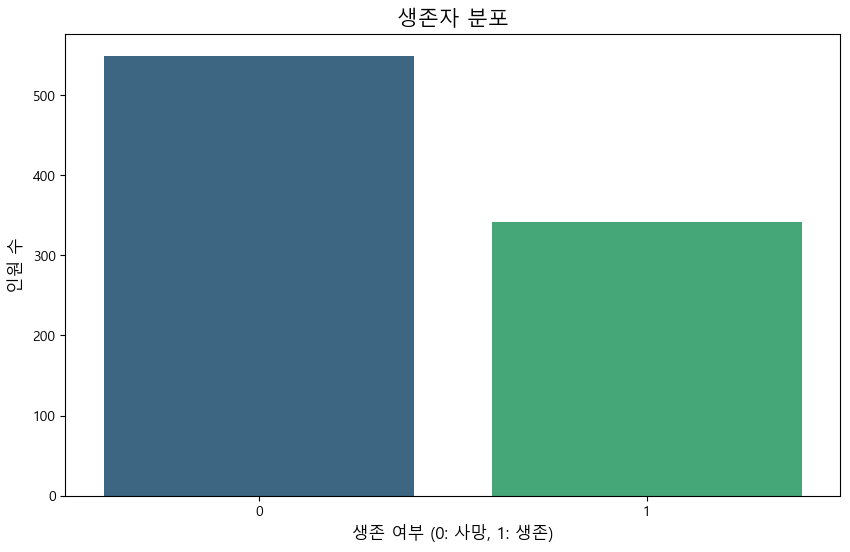

In [5]:
# 생존자 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='Survived', data=train_df_viz, palette='viridis')
plt.title('생존자 분포', fontsize=15)
plt.xlabel('생존 여부 (0: 사망, 1: 생존)', fontsize=12)
plt.ylabel('인원 수', fontsize=12)

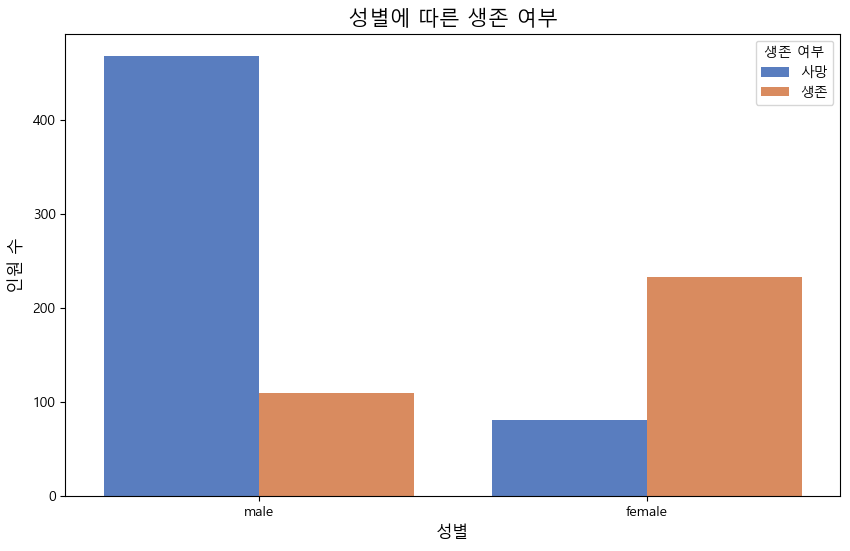

In [6]:
# 성별과 생존 관계
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=train_df_viz, palette='muted')
plt.title('성별에 따른 생존 여부', fontsize=15)
plt.xlabel('성별', fontsize=12)
plt.ylabel('인원 수', fontsize=12)
plt.legend(title='생존 여부', labels=['사망', '생존'])

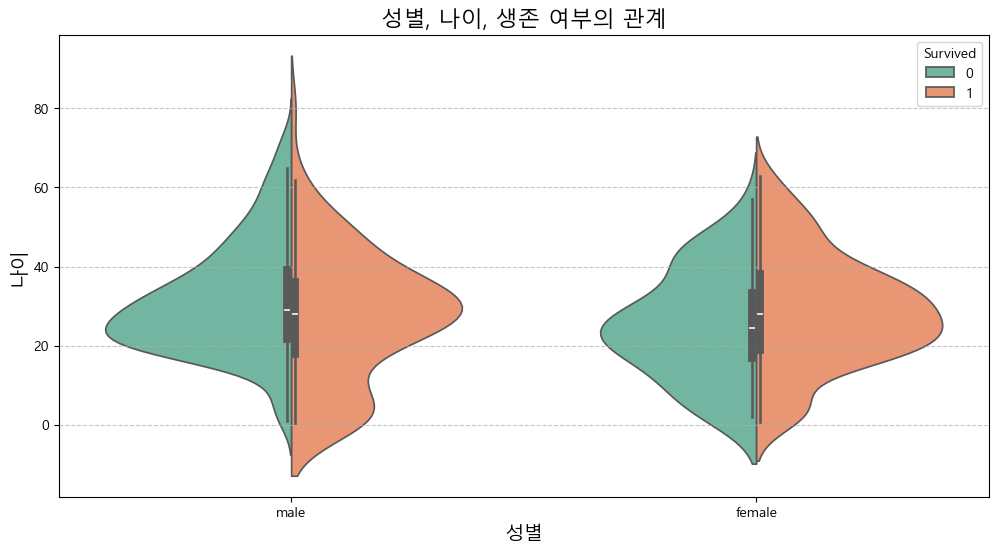

In [7]:
# 나이, 성별, 생존 관계를 보여주는 바이올린 플롯
plt.figure(figsize=(12, 6))
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train_df_viz.dropna(subset=['Age']),
               split=True, palette='Set2')
plt.title('성별, 나이, 생존 여부의 관계', fontsize=16)
plt.xlabel('성별', fontsize=14)
plt.ylabel('나이', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<Figure size 1200x600 with 0 Axes>

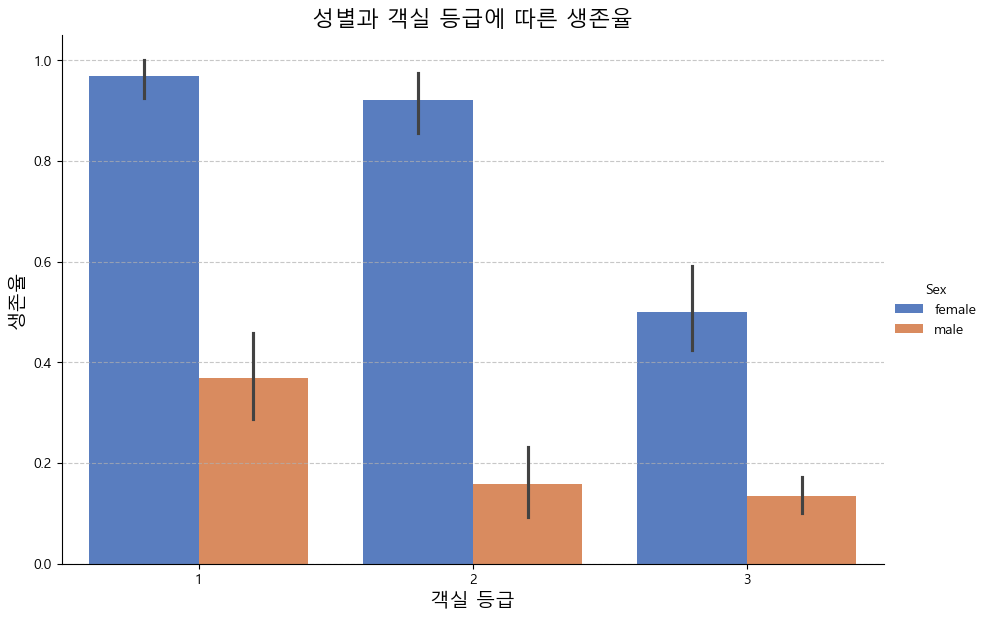

In [8]:
# 성별과 객실 등급에 따른 생존율 (인터랙션 효과) , 검은색 선은 오차
plt.figure(figsize=(12, 6))
sns.catplot(x='Pclass', y='Survived', hue='Sex', kind='bar', data=train_df_viz, height=6, aspect=1.5, palette='muted')
plt.title('성별과 객실 등급에 따른 생존율', fontsize=16)
plt.xlabel('객실 등급', fontsize=14)
plt.ylabel('생존율', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
# 히트맵으로 변수 간 상관관계 확인 (전처리된 데이터 사용)
plt.figure(figsize=(12, 8))
X_train_df = pd.DataFrame(X_train.reshape(X_train.shape[0], X_train.shape[2]), columns=train_df.drop('Survived', axis=1).columns)

# 상관계수 행렬 계산
corr_matrix = X_train_df.corr()
# 히트맵 그리기
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('변수 간 상관관계 히트맵 (전처리 후)', fontsize=16)
plt.tight_layout()
plt.show()

NameError: name 'X_train' is not defined

<Figure size 1200x800 with 0 Axes>

In [10]:
# 연령별 생존률
plt.hist(x=[train_df.Age[train_df.Survived==0], train_df.Age[train_df.Survived==1]], bins=8, histtype='barstacked', label=['Death', 'Surveved'])
plt.legend()

NameError: name 'train_df' is not defined

In [11]:
# SHAP 분석을 위한 함수 정의
def f(X):
    # SHAP은 원본 입력 형태를 요구하므로 LSTM 입력 형태로 변환
    X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])
    return model.predict(X_reshaped).flatten()  # flatten()을 추가해 1차원 배열로 변환

# 원본 형태의 데이터로 SHAP 분석 준비 (시각화용 샘플 제한)
X_sample = X_val.reshape(X_val.shape[0], X_val.shape[2])
X_sample = X_sample[:100]  # 계산 시간 단축을 위해 100개 샘플만 사용

# 백그라운드 데이터 생성
background = shap.sample(X_sample, 10)  # 10개의 배경 데이터 샘플링

# 특성 이름 확인 (디버깅용)
print("특성 이름:", feature_names)
print("X_sample 형태:", X_sample.shape)

# SHAP 값 계산 (KernelExplainer 사용)
explainer = shap.KernelExplainer(f, background)
shap_values = explainer.shap_values(X_sample)

# 모든 특성을 강제로 표시하기 위한 설정
max_display = len(feature_names)  # 모든 특성 표시
print("SHAP 값 형태:", np.array(shap_values).shape)
print("특성별 중요도:", np.abs(shap_values).mean(0))

# Title이 포함된 그래프 생성 방식 수정
# 중요도 막대 그래프
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                 plot_type="bar", show=False, max_display=max_display)
plt.title("SHAP 변수 중요도", fontsize=14)
plt.tight_layout()
plt.show()

# 변수별 영향도
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                 show=False, max_display=max_display)
plt.title("SHAP 변수별 영향도", fontsize=14)
plt.tight_layout()
plt.show()

# 개별 변수 의존성 플롯 (상위 3개만)
# 중요도 순으로 특성 인덱스 정렬
importance = np.abs(shap_values).mean(0)
sorted_idx = np.argsort(-importance)
top_features = [feature_names[i] for i in sorted_idx[:3]]  # 상위 3개 특성

print("상위 3개 중요 특성:", top_features)

# 상위 특성에 대해서만 의존성 플롯 생성
for idx in sorted_idx[:3]:
    feature = feature_names[idx]
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(idx, shap_values, X_sample, feature_names=feature_names, show=False)
    plt.title(f"{feature} 변수의 SHAP 의존성 플롯", fontsize=14)
    plt.tight_layout()
    plt.show()

NameError: name 'X_val' is not defined